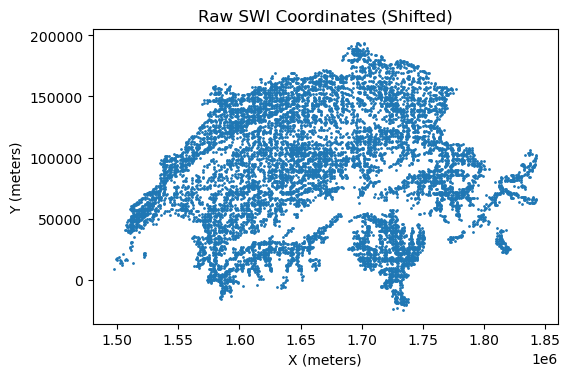

In [5]:
from pyproj import Transformer
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


np.set_printoptions(threshold=np.inf)      # print entire array, no truncation
np.set_printoptions(linewidth=np.inf) 

env=pd.read_csv("data_SDM_NCEAS/SWItest_env.csv")
#lats, lons = coord_trans(env["x"].values, env["y"].values)





plt.figure(figsize=(6, 10))
plt.scatter(env["x"], env["y"], s=1)
plt.gca().set_aspect('equal', 'box')
plt.title("Raw SWI Coordinates (Shifted)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()

shifted minimum x: 1497037.5
shifted minimum y: -25062.5
actual minimum x: 485410.0090516365
actual minimum y: 75263.6477937577
1011627.4909483634 -100326.1477937577


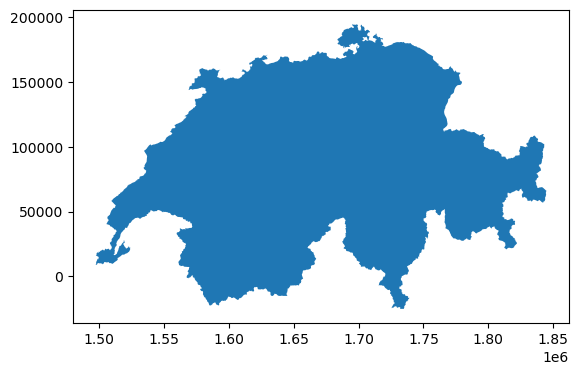

In [17]:
borders=gpd.read_file("data_SDM_NCEAS/Borders/swi.gpkg")
minx, miny, maxx, maxy = borders.total_bounds

print("shifted minimum x:", minx)
print("shifted minimum y:", miny)
borders.plot()

#46.132366, 5.955899    Minimizing west point
#45.817921, 9.017064    Minimizing south point

from pyproj import Transformer

def coord_trans(x, y, order="CH_to_normal"):

    if order == "CH_to_normal":
        transformer = Transformer.from_crs("EPSG:21781", "EPSG:4326", always_xy=True)
        x_out, y_out = transformer.transform(x, y)  # X=Easting, Y=Northing
    elif order == "normal_to_CH":
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781", always_xy=True)
        x_out, y_out = transformer.transform(x, y)  # X=Longitude, Y=Latitude
    else:
        raise ValueError("order must be either 'CH_to_normal' or 'normal_to_CH'")
    return x_out, y_out


We_min=coord_trans(5.955899 ,46.132366 , order="normal_to_CH") #coords from google maps: First longitude! always x,y
So_min=coord_trans(9.017064, 45.817921,order="normal_to_CH")
print("actual minimum x:", We_min[0])
print("actual minimum y:", So_min[1])
shift_x=minx-We_min[0]
shift_y=miny-So_min[1]
print(shift_x, shift_y)



In [7]:
#Test:

lons, lats = coord_trans(env["x"].values-shift_x, env["y"].values-shift_y,order="CH_to_normal")

print(lons.shape)
lons, lats

idx_east = np.argmin(lons)   # index of the maximum longitude
lat_east = lats[idx_east]
lon_east = lons[idx_east]

print(lat_east, lon_east) #eastern point fall 200m beyond the border...

idx_east = np.argmax(lats)   # index of the maximum longitude
lat_east = lats[idx_east]
lon_east = lons[idx_east]

print(lat_east, lon_east) #eastern point fall 200m beyond the border...

(10013,)
46.12521834952867 5.956255309022179
47.79357289591076 8.565322361150569


/tmp/ipykernel_1231238/3177588617.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = borders.boundary.unary_union  # Merge all boundaries


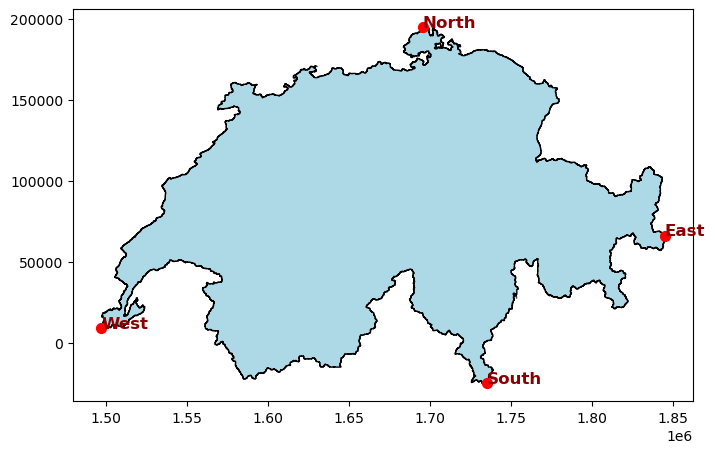

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load Switzerland borders
borders = gpd.read_file("data_SDM_NCEAS/Borders/swi.gpkg")

# Get the boundary as a LineString (or MultiLineString)
boundary = borders.boundary.unary_union  # Merge all boundaries

# Extract extremal points
minx_point = maxx_point = miny_point = maxy_point = None
minx_val = float('inf')
maxx_val = -float('inf')
miny_val = float('inf')
maxy_val = -float('inf')

# Iterate over all points in the boundary
for geom in boundary.geoms if hasattr(boundary, 'geoms') else [boundary]:
    for x, y in geom.coords:
        if x < minx_val:
            minx_val = x
            minx_point = Point(x, y)
        if x > maxx_val:
            maxx_val = x
            maxx_point = Point(x, y)
        if y < miny_val:
            miny_val = y
            miny_point = Point(x, y)
        if y > maxy_val:
            maxy_val = y
            maxy_point = Point(x, y)

# Combine into GeoDataFrame
extremal_points = gpd.GeoDataFrame(
    geometry=[minx_point, maxx_point, miny_point, maxy_point],
    crs=borders.crs
)

# Plot
ax = borders.plot(color='lightblue', edgecolor='black', figsize=(8,6))
extremal_points.plot(ax=ax, color='red', markersize=50)

# Optional: label the points
labels = ['West', 'East', 'South', 'North']
for point, label in zip(extremal_points.geometry, labels):
    plt.text(point.x, point.y, label, fontsize=12, fontweight='bold', color='darkred')

plt.show()


Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


<Axes: >

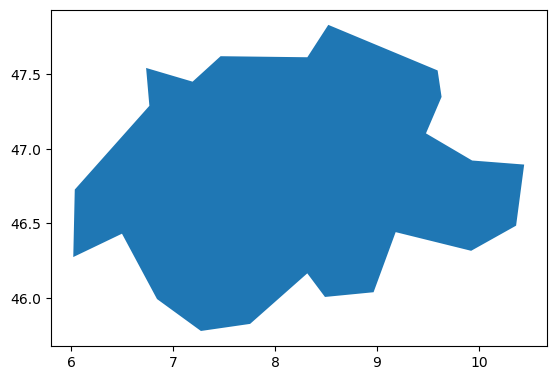

In [9]:
#inal test: plot on map:

boundaries = gpd.read_file("data_SDM_NCEAS/borders_natural_earth/ne_110m_admin_0_countries.shp")
#boundaries.plot() 
print(boundaries.columns) 
switzerland = boundaries[boundaries['NAME'] == 'Switzerland'] 
switzerland.plot()

The following should be launched with "geopandas3". It is very independent from the first part of the document, that was mostly focused around getting the coordinates right. 
Here we plot the principal components of PCA of the embeddings over maps.

In [2]:
#Model, dataloader
from sklearn.decomposition import IncrementalPCA
import numpy as np
import importlib
import utils
from tqdm import tqdm
import torch
import torch.nn as nn
import joblib
importlib.reload(utils)
device="cuda"
batch_size=4096
save_name="save_14_to_17-10-25"
data_path="/home/adam/source/CLIP/full_dataset_embeddings.h5"

dataloader, _ =utils.dataloader_emb(data_path,batch_size=batch_size)
#hyperparameters:
#pos. layer sizes
#we first upscale from 2 to dim_fourrier_encoding, with the fourrier encodding
dim_fourier_encoding=64 #multiple of 4!!
dim_hidden=256
dim_emb=128 #this one is actually shared with img embeddings

#dim image layer size: 
#As of now: linear from 768 to dim_emb. We could also have MLP if non-linearity needed


image_encoder=nn.Linear(768,dim_emb).to(device)
pos_encoder=utils.Fourier_MLP(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb).to(device)
model= utils.DoubleNetwork(image_encoder,pos_encoder).to(device)
img_enc=model.image_encoder

/home/adam/anaconda3/envs/geopandas3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina', 'Dhekelia', 'Cyprus', 'India', 'China', 'Israel', 'Palestine', 'Lebanon', 'Ethiopia', 'S. Sudan', 'Somalia', 'Kenya', 'Malawi', 'Tanzania', 'Syria', 'Somaliland', 'France', 'Suriname', 'Guyana', 'South Korea', 'North Korea', 'Morocco', 'W. Sahara', 'Costa Rica', 'Nicaragua', 'Congo', 'Dem. Rep. Congo', 'Bhutan', 'Ukraine', 'Belarus', 'Namibia', 'South Africa', 'St-Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan', 'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia', 'Russia', 'Czechia', 'Germany', 'Estonia', 'Latvia', 'Norway', 'Sweden', 'Finland', 'Vietnam', 'Cambodia', 'Luxembourg', 'United Arab Emirates', 'Belgium', 'Georgia', 'North Macedonia', 'Albania', 'Azerbaijan', 'Kosovo', 'Turkey', 'Spain', 'Laos', 'Kyrgyzstan', 'Armenia', 'Denmark', 'Libya', 'Tunisia', 'Romania', 'Hungary', 'Slovakia', 'Poland', 'Ireland', 'United Kingdom', 'Greece', 'Zambia', 'Sierra Leone', 'Guinea', 'Liberia', 'Central Af

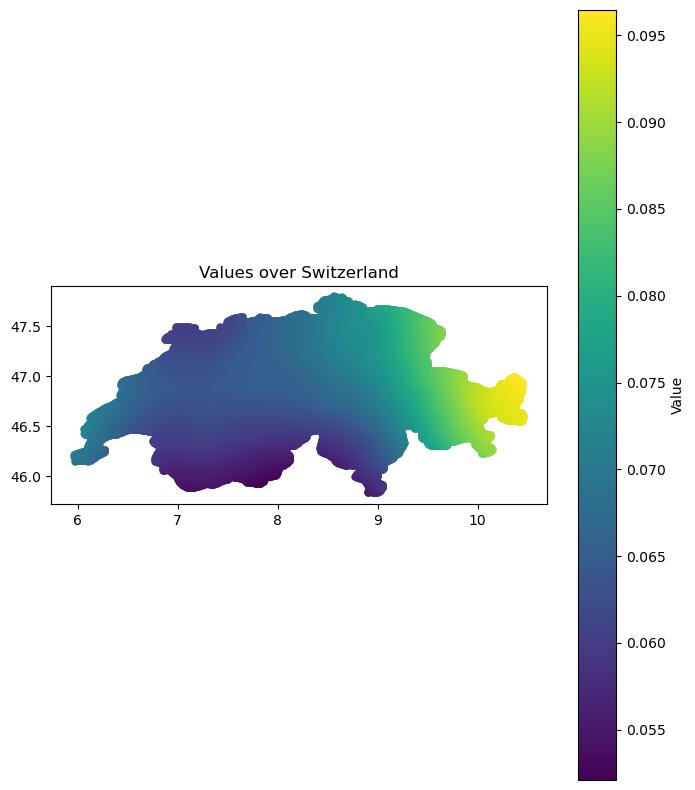

['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina', 'Dhekelia', 'Cyprus', 'India', 'China', 'Israel', 'Palestine', 'Lebanon', 'Ethiopia', 'S. Sudan', 'Somalia', 'Kenya', 'Malawi', 'Tanzania', 'Syria', 'Somaliland', 'France', 'Suriname', 'Guyana', 'South Korea', 'North Korea', 'Morocco', 'W. Sahara', 'Costa Rica', 'Nicaragua', 'Congo', 'Dem. Rep. Congo', 'Bhutan', 'Ukraine', 'Belarus', 'Namibia', 'South Africa', 'St-Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan', 'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia', 'Russia', 'Czechia', 'Germany', 'Estonia', 'Latvia', 'Norway', 'Sweden', 'Finland', 'Vietnam', 'Cambodia', 'Luxembourg', 'United Arab Emirates', 'Belgium', 'Georgia', 'North Macedonia', 'Albania', 'Azerbaijan', 'Kosovo', 'Turkey', 'Spain', 'Laos', 'Kyrgyzstan', 'Armenia', 'Denmark', 'Libya', 'Tunisia', 'Romania', 'Hungary', 'Slovakia', 'Poland', 'Ireland', 'United Kingdom', 'Greece', 'Zambia', 'Sierra Leone', 'Guinea', 'Liberia', 'Central Af

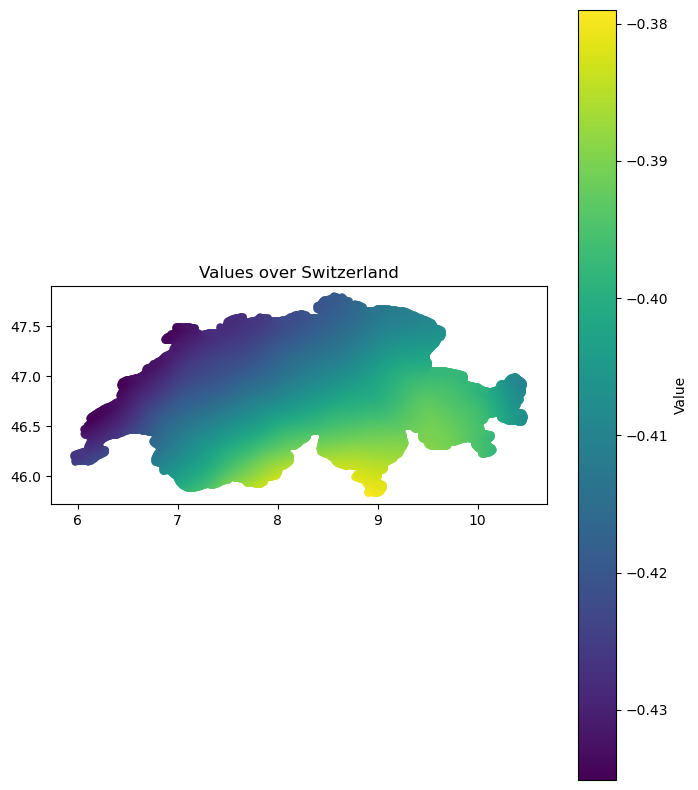

['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina', 'Dhekelia', 'Cyprus', 'India', 'China', 'Israel', 'Palestine', 'Lebanon', 'Ethiopia', 'S. Sudan', 'Somalia', 'Kenya', 'Malawi', 'Tanzania', 'Syria', 'Somaliland', 'France', 'Suriname', 'Guyana', 'South Korea', 'North Korea', 'Morocco', 'W. Sahara', 'Costa Rica', 'Nicaragua', 'Congo', 'Dem. Rep. Congo', 'Bhutan', 'Ukraine', 'Belarus', 'Namibia', 'South Africa', 'St-Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan', 'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia', 'Russia', 'Czechia', 'Germany', 'Estonia', 'Latvia', 'Norway', 'Sweden', 'Finland', 'Vietnam', 'Cambodia', 'Luxembourg', 'United Arab Emirates', 'Belgium', 'Georgia', 'North Macedonia', 'Albania', 'Azerbaijan', 'Kosovo', 'Turkey', 'Spain', 'Laos', 'Kyrgyzstan', 'Armenia', 'Denmark', 'Libya', 'Tunisia', 'Romania', 'Hungary', 'Slovakia', 'Poland', 'Ireland', 'United Kingdom', 'Greece', 'Zambia', 'Sierra Leone', 'Guinea', 'Liberia', 'Central Af

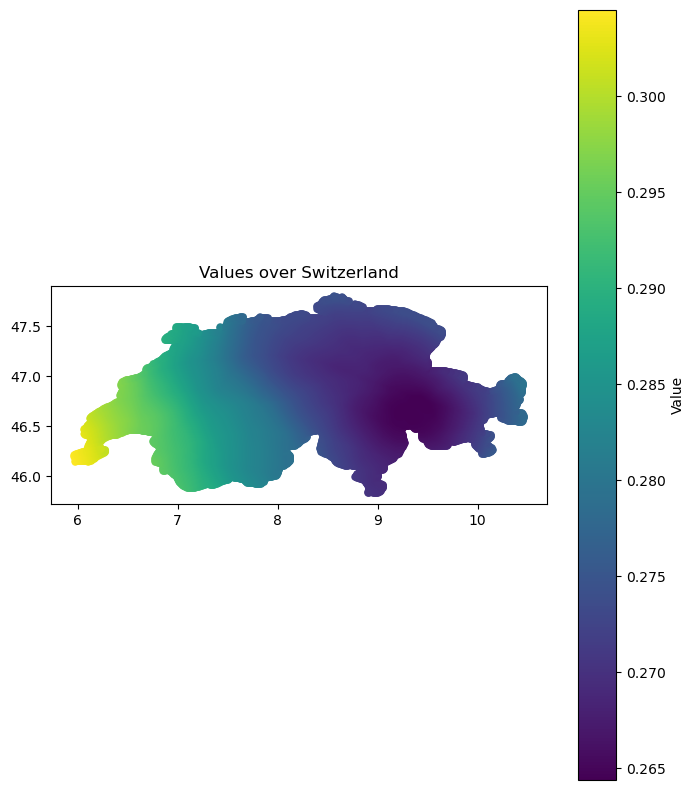

['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina', 'Dhekelia', 'Cyprus', 'India', 'China', 'Israel', 'Palestine', 'Lebanon', 'Ethiopia', 'S. Sudan', 'Somalia', 'Kenya', 'Malawi', 'Tanzania', 'Syria', 'Somaliland', 'France', 'Suriname', 'Guyana', 'South Korea', 'North Korea', 'Morocco', 'W. Sahara', 'Costa Rica', 'Nicaragua', 'Congo', 'Dem. Rep. Congo', 'Bhutan', 'Ukraine', 'Belarus', 'Namibia', 'South Africa', 'St-Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan', 'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia', 'Russia', 'Czechia', 'Germany', 'Estonia', 'Latvia', 'Norway', 'Sweden', 'Finland', 'Vietnam', 'Cambodia', 'Luxembourg', 'United Arab Emirates', 'Belgium', 'Georgia', 'North Macedonia', 'Albania', 'Azerbaijan', 'Kosovo', 'Turkey', 'Spain', 'Laos', 'Kyrgyzstan', 'Armenia', 'Denmark', 'Libya', 'Tunisia', 'Romania', 'Hungary', 'Slovakia', 'Poland', 'Ireland', 'United Kingdom', 'Greece', 'Zambia', 'Sierra Leone', 'Guinea', 'Liberia', 'Central Af

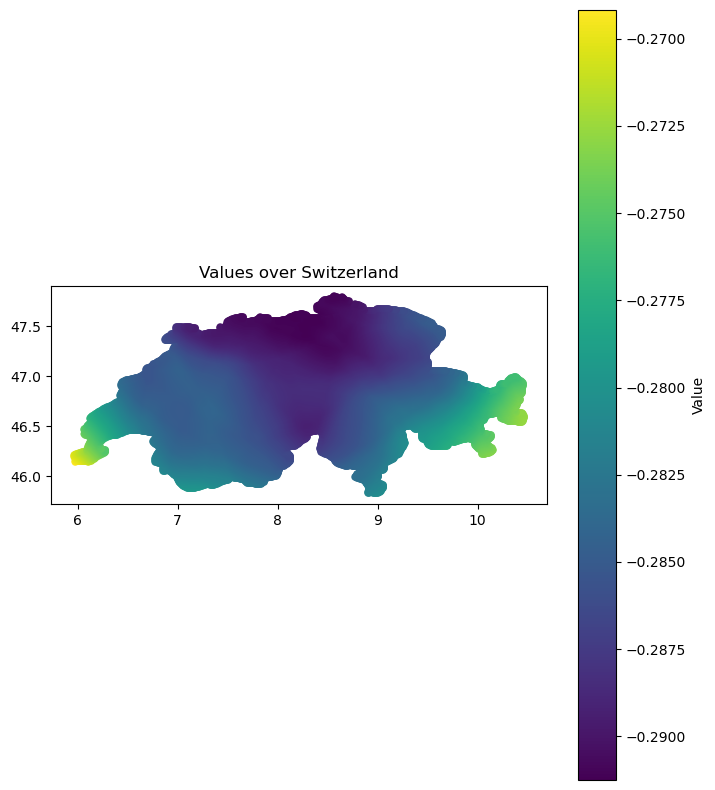

['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina', 'Dhekelia', 'Cyprus', 'India', 'China', 'Israel', 'Palestine', 'Lebanon', 'Ethiopia', 'S. Sudan', 'Somalia', 'Kenya', 'Malawi', 'Tanzania', 'Syria', 'Somaliland', 'France', 'Suriname', 'Guyana', 'South Korea', 'North Korea', 'Morocco', 'W. Sahara', 'Costa Rica', 'Nicaragua', 'Congo', 'Dem. Rep. Congo', 'Bhutan', 'Ukraine', 'Belarus', 'Namibia', 'South Africa', 'St-Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan', 'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia', 'Russia', 'Czechia', 'Germany', 'Estonia', 'Latvia', 'Norway', 'Sweden', 'Finland', 'Vietnam', 'Cambodia', 'Luxembourg', 'United Arab Emirates', 'Belgium', 'Georgia', 'North Macedonia', 'Albania', 'Azerbaijan', 'Kosovo', 'Turkey', 'Spain', 'Laos', 'Kyrgyzstan', 'Armenia', 'Denmark', 'Libya', 'Tunisia', 'Romania', 'Hungary', 'Slovakia', 'Poland', 'Ireland', 'United Kingdom', 'Greece', 'Zambia', 'Sierra Leone', 'Guinea', 'Liberia', 'Central Af

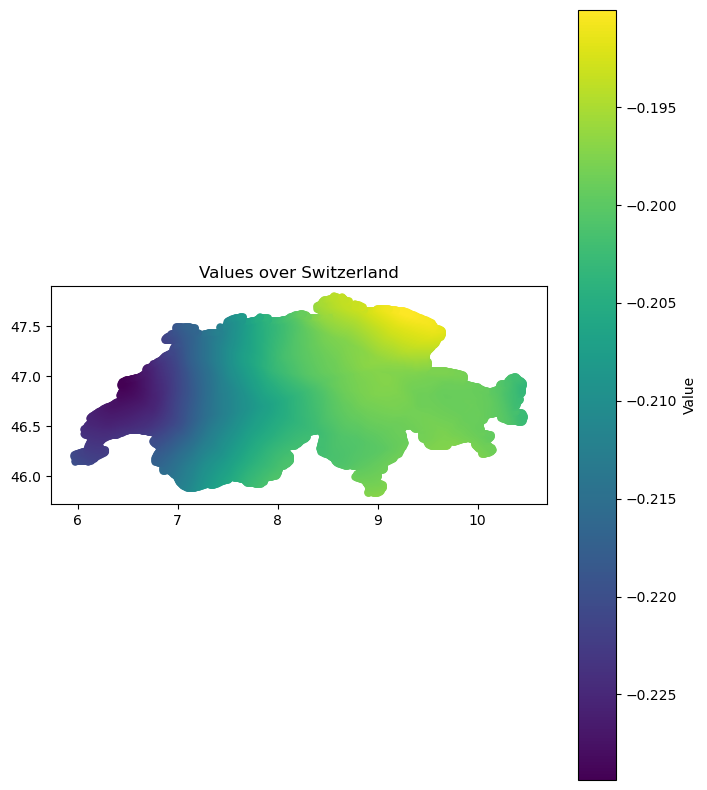

In [5]:
#Plotting the principal components of the embedding vectors

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely import geometry as geom
import regionmask
import joblib
import torch

def create_country_grid(country_name, grid_resolution=0.1):
    # Load 110m Natural Earth countries
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_10
    print(list(countries.names))
    # Find the index of the country
    try:
        idx = list(countries.names).index(country_name)
    except ValueError:
        raise ValueError(f"Country '{country_name}' not found in regionmask.")

    polygon = countries.polygons[idx]
    if country_name=="France":
        # Natural Earth polygons are MultiPolygon objects
        parts = list(polygon.geoms)

        # Metropolitan France lies roughly between lon -5 to 10 and lat 42 to 52
        bbox_metro = geom.box(minx=-10, miny=40, maxx=15, maxy=55)

        # Keep only polygons that intersect this box
        metro_parts = [p for p in parts if p.intersects(bbox_metro)]

        if len(metro_parts) == 0:
            raise RuntimeError("Could not isolate metropolitan France polygon.")

        polygon = geom.MultiPolygon(metro_parts)
    # Create a lon/lat grid covering the bounding box
    minx, miny, maxx, maxy = polygon.bounds
    lon_grid = np.arange(minx, maxx, grid_resolution)
    lat_grid = np.arange(miny, maxy, grid_resolution)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    coords = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

    # Keep only points inside the polygon
    coords_inside = np.array([coord for coord in coords if polygon.contains(Point(coord))])
    print (coords_inside.shape)
    coords_inside= torch.tensor(coords_inside, dtype=torch.float32)
    return coords_inside #returns a torch tensor


def create_countries_grid(country_names, grid_resolution=0.1):
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_10
    all_coords = []

    for country_name in country_names:
        try:
            idx = list(countries.names).index(country_name)
        except ValueError:
            print(f"Warning: Country '{country_name}' not found in regionmask. Skipping.")
            continue

        polygon = countries.polygons[idx]
        minx, miny, maxx, maxy = polygon.bounds
        lon_grid = np.arange(minx, maxx, grid_resolution)
        lat_grid = np.arange(miny, maxy, grid_resolution)
        lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
        coords = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])
        
        coords_inside = np.array([coord for coord in coords if polygon.contains(Point(coord))])
        all_coords.append(coords_inside)

    if all_coords:
        all_coords = np.vstack(all_coords)
        return torch.tensor(all_coords, dtype=torch.float32)
    else:
        return torch.empty((0, 2), dtype=torch.float32)



def plot_country_values(country_name, coord_trans, grid_resolution=0.1, cmap='viridis',device="cuda",comp_idx=0):
    coords = create_country_grid(country_name, grid_resolution)
    values = coord_trans(coords.to(device),comp_idx=comp_idx)#np.array([coord_trans(coord) for coord in coords])

    # Get the country polygon
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_10
    idx = list(countries.names).index(country_name)
    polygon = countries.polygons[idx]
    if country_name=="France":
        # Natural Earth polygons are MultiPolygon objects
        parts = list(polygon.geoms)

        # Metropolitan France lies roughly between lon -5 to 10 and lat 42 to 52
        bbox_metro = geom.box(minx=-10, miny=40, maxx=15, maxy=55)

        # Keep only polygons that intersect this box
        metro_parts = [p for p in parts if p.intersects(bbox_metro)]
        if len(metro_parts) == 0:
            raise RuntimeError("Could not isolate metropolitan France polygon.")

        polygon = geom.MultiPolygon(metro_parts)
    boundary = gpd.GeoSeries([polygon])

    fig, ax = plt.subplots(figsize=(8, 10))
    boundary.plot(ax=ax, color="none", edgecolor="black")
    sc = ax.scatter(coords[:, 0], coords[:, 1], c=values, cmap=cmap, s=20)
    plt.colorbar(sc, ax=ax, label="Value")
    ax.set_title(f"Values over {country_name}")
    plt.show()



def coord_to_PCA(coords, pos_enc=model.pos_encoder,pca_model_path="PCA_All_comp_full_dataset_Normalized.pkl", comp_idx=1):  #coordinates of the embbeddings in the PCA basis
    pca_model=joblib.load(pca_model_path)
    embeddings=pos_enc(coords).cpu()
    vect_to_plot = pca_model.transform(embeddings.detach().numpy())
    return vect_to_plot[:,comp_idx]

for i in range(5):
    plot_country_values("Switzerland", coord_to_PCA,comp_idx=i,grid_resolution=0.01)

